<a href="https://colab.research.google.com/github/eyalgur1/Machine_Learning_Techniques/blob/main/RegressionComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Packages and Data Generation**🚫

In [153]:
#@title **Import Packages**🚫
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
from IPython.display import Latex
import sklearn
import sklearn.ensemble
import sklearn.tree
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import xgboost as xgb
import importlib
plt.rcParams.update({
    "text.usetex": True,             # Use LaTeX for all text
    "font.family": "serif",          # Use serif fonts
    "font.serif": ["Computer Modern Roman"],  # Use Computer Modern Roman font
    "text.latex.preamble": r"\usepackage{amsmath}",  # Load additional packages
    "font.size": 16,                 # Default font size
    "axes.titlesize": 18,            # Title font size
    "axes.labelsize": 14,            # Axis labels font size
    "xtick.labelsize": 14,           # X-tick labels font size
    "ytick.labelsize": 14,           # Y-tick labels font size
    "legend.fontsize": 14
})

#from google.colab import drive
#drive.mount("/content/drive/")

In [120]:
#@title **Functions for Generation of Tabular Data**🚫

def createTabularData(features, target, scaler, val_per, test_per):
    # Input:
    # features: a numerical array of column features
    # target: a numerical array of target labels
    # scaler: a string with 'minmax' or 'standard' data scaler
    # Output:
    # dataset: dictionary with 6 items: feature_train/val/test and target_train/val/test


    # Split to train/validation/test sets (before preprocessing)
    X_train_pre, X_remain, y_train_pre, y_remain = train_test_split(features, target.reshape(-1,1), test_size=val_per+test_per, random_state=1)  # split and fix the seed
    X_val_pre, X_test_pre, y_val_pre, y_test_pre = train_test_split(X_remain, y_remain, test_size=test_per/(val_per+test_per), random_state=1)


    # Initialize scalers to normalize the data to have the same scale
    if scaler.lower() in ['minmax']:
        scaler_X = sklearn.preprocessing.MinMaxScaler()  # initializes a scaler that scales any column to [0,1] (column-wise)
        scaler_y = sklearn.preprocessing.MinMaxScaler()  # scaler for y
    elif scaler.lower() in ['standard']:
        scaler_X = sklearn.preprocessing.StandardScaler()  # initializes a scaler by removing the mean and scaling to unit variance (column-wise)
        scaler_y = sklearn.preprocessing.StandardScaler()  # scaler for y
    else:
        raise ValueError("No scaler named '"+scaler.lower()+"'. Set scaler='minmax' or scaler='standard'.")


    # Scale the data according to the training set
    # Tranforms that data according to the limits already set by the training set
    X_train = scaler_X.fit_transform(X_train_pre)
    X_val, X_test = (scaler_X.transform(X_val_pre), scaler_X.transform(X_test_pre))
    y_train = scaler_y.fit_transform(y_train_pre)
    y_val, y_test = (scaler_y.transform(y_val_pre), scaler_y.transform(y_test_pre))


    tabular_train_dataset = dict(feature_train = X_train, target_train = y_train)
    tabular_val_dataset = dict(feature_val = X_val, target_val = y_val)
    tabular_test_dataset = dict(feature_test = X_test, target_test = y_test)
    inverse_scalers = dict(inv_feature_scale = scaler_X.inverse_transform,
                           inv_target_scale = scaler_y.inverse_transform)
    return tabular_train_dataset, tabular_val_dataset, tabular_test_dataset, inverse_scalers


# Auxiliary function for dynamic data import by the user
def dynamic_import(module_name: str, object_name: str):
    # Import the module dynamically
    module = importlib.import_module(module_name)

    # Import the specific object from the module
    imported_object = getattr(module, object_name)

    return imported_object

## **Implementation of Regressors**🚫

In [ ]:
#@title **Functions for Instantiation of Regressors**🚫
#@markdown For the regression task, we use the following six regressors: Decision Tree, Bagged Trees, Random Forest, Gradient Boosting, Linear Regression, and Neural Network.
"Decision Tree"
# Decision tree regressor: predicts the value of a target variable by learning simple (if-then-else) decision rules.
# A tree can be seen as a piecewise constant approximation.
def decisionTreeReg(max_depth):
    return sklearn.tree.DecisionTreeRegressor(max_depth=max_depth)


"Bagged Trees"
# Bagging regressor: fits base regressors each on random subsets of the original dataset,
# and then aggregates their individual predictions (by averaging) to form a final prediction.
# Reduces the variance of an estimator by introducing randomization.
# This implementaion considers all dataset (hence, just shuffles the data for each tree).
# def baggedTreesReg(n_estimators, max_depth):
#     return sklearn.ensemble.BaggingRegressor(estimator=sklearn.tree.DecisionTreeRegressor(max_depth=max_depth),
#                                          n_estimators=n_estimators, verbose = 1,
#                                          warm_start = True)


"Random Forest"
# Random forest regressor: fits a number of decision tree regressors on (possibly various random sub-samples of) the dataset,
# by randomly selecting a sub-set of the features at each split,
# and averages to improve the predictive accuracy and control over-fitting.
# Equivalent to Bagged Trees if selecting all features at each split.
# This implementaion considers all dataset (hence, just shuffles the data for each tree).
def randomForestReg(n_estimators, max_depth):
    return sklearn.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features = "sqrt")


"Gradient Boosting"
# Gradient boosting regressor: a functional gradient descent on fitted trees,
# where at iteration we fit a tree using the previous fits as a "descent direction".
# Here we use XGBoost as an API for sklearn.
#def gradBoostReg(n_estimators, max_depth, lr):
 #   return xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators,
  #                               learning_rate=lr, max_depth=max_depth, eval_metric=['rmse'])


"Linear Regression"
# Linear regressor: a simple l2-regression with exact solution.
# Using a polynomial linear regression for multi-feature setting is expensive,
# as the Vandermonde matrix is too large for accurate inversion even when the poly degree is small.
# For a polynomial linear regression, one can use gradient descent.
def linearReg(intercept=False):
    def leastSqaures(A, b):
        if ~intercept:  # if intercept is not required
            A = np.append(np.ones((A.shape[0], 1)), A, 1)  # append column of ones for free coefficient (Vendermonde)
        AT = np.transpose(A)
        return 0.5*np.linalg.inv(AT@A)@AT@b  # return least squares solution
    return leastSqaures


"Neuarl Network"
# Neural network regressor: a simple regression PyTorch net with one hidden layer.
# The activation function is ReLU, optimizer is Adam, loss is MSELoss, and lr is given by the user.
# This function returns the model, criterion (loss), and the optimizer.
def neuralNetReg(input_dim, hidden_dim, output_dim, lr):

    class SimpleRegressionModel(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(SimpleRegressionModel, self).__init__()
            self.hidden = nn.Linear(input_dim, hidden_dim)
            self.relu = nn.ReLU()
            self.output = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            x = self.hidden(x)
            x = self.relu(x)
            x = self.output(x)

    model = SimpleRegressionModel(input_dim, hidden_dim, output_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return model, criterion, optimizer

Gradient Boosting Regressor Training 

Notice: validation_0=Training Set, validation_1=Validation Set 

Epoch  1 / 2
[0]	validation_0-rmse:0.07148	validation_1-rmse:0.06514
[99]	validation_0-rmse:0.02335	validation_1-rmse:0.02766
Epoch  2 / 2
[0]	validation_0-rmse:0.02333	validation_1-rmse:0.02765
[99]	validation_0-rmse:0.01863	validation_1-rmse:0.02827


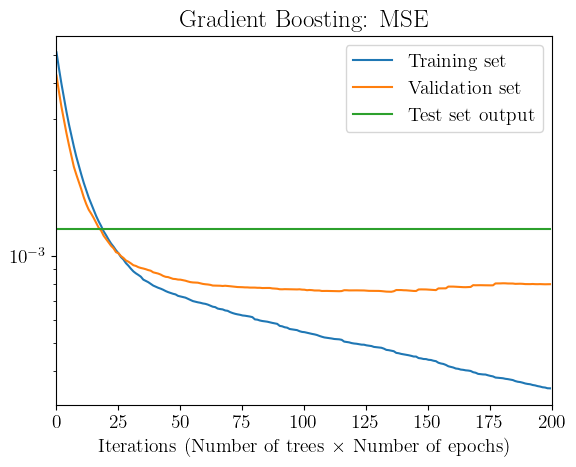

In [154]:
#@title *Gradient Boosting Trainer*
def gradBoostRegTrain(data_train, data_val, data_test, num_epochs, n_estimators, lr, max_depth):

    gradBoost = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = n_estimators,
                                 learning_rate = lr, max_depth = max_depth, eval_metric = ['rmse'])

    X_train = data_train['feature_train'];  y_train = data_train['target_train']
    X_test = data_test['feature_test'];  y_test = data_test['target_test']
    eval_set = [(X_train, y_train), (data_val['feature_val'], data_val['target_val'])]
    verbosity = gradBoost.n_estimators
    results = {'mse_train':np.array([]), 'mse_val':np.array([]), 'mse_test':0}

    print("\033[4mGradient Boosting Regressor Training\033[0m", '\n')
    print("Notice: validation_0=Training Set, validation_1=Validation Set", '\n')


    # Training loop
    for epoch in range(num_epochs):
        print('Epoch ', str(epoch+1), '/', str(num_epochs))
        if epoch == 0:  # first epoch
            gradBoost.fit(X_train, y_train, eval_set=eval_set, verbose=verbosity)
            # eval_set: the data on which to track metric evaluation; can also be set as eval_set=[(X_train, y_train)]; eval_set is not used for training
            # verbose: integer specifying the intervals of trees to specify metrics for (out of n_estimators in total)
        else:
            gradBoost.fit(X_train, y_train, eval_set=eval_set, verbose=verbosity, xgb_model=gradBoost.get_booster())
            # after the first epoch, we use the previous fitted model as starting point with the command xgb_model=xgb_model.get_booster()


        # Save MSE for later plotting
        results_epoch = gradBoost.evals_result()
        results['mse_train'] = np.append(results['mse_train'], np.array(results_epoch['validation_0']['rmse'])**2)
        results['mse_val'] = np.append(results['mse_val'], np.array(results_epoch['validation_1']['rmse'])**2)

    y_pred = gradBoost.predict(X_test).ravel()
    results['mse_test'] = mean_squared_error(y_test, y_pred)

    return gradBoost, results


def gradBoostPlot(gradBoost, results):
    # Training and validation sets
    plt.semilogy(results['mse_train'])  # the training set
    plt.semilogy(results['mse_val'])  # the validation set
    plt.title('Gradient Boosting: MSE')
    plt.xlabel(r'Iterations (Number of trees $\times$ Number of epochs)')
    plt.legend(['Training set','Validation set'])
    xlim = gradBoost.n_estimators*num_epochs
    plt.xlim([0, xlim])

    # Test set prediction
    plt.semilogy(np.ones((xlim, 1))*results['mse_test'])
    plt.legend(['Training set', 'Validation set', 'Test set output'])
    plt.show()

gradBoost, results = gradBoostRegTrain(data_train, data_val, data_test, num_epochs, n_estimators_GB, lr_GB, max_depth_GB)
gradBoostPlot(gradBoost, results)

In [155]:
#@title *Bagged Trees Trainer*

def baggedTreesRegTrain(data_train, data_val, num_epochs, max_depth, n_estimators):

    X_train = data_train['feature_train'];  y_train = data_train['target_train'].ravel()
    X_val = data_val['feature_val']; y_val = data_val['target_val']
    trees_per_epoch = n_estimators // num_epochs
    results = {'train_mse':np.array([]), 'val_mse':np.array([])}

    baggedTrees = sklearn.ensemble.BaggingRegressor(estimator=sklearn.tree.DecisionTreeRegressor(max_depth=max_depth),
                                         n_estimators = trees_per_epoch, verbose = 1,
                                         warm_start = True)

    print("\033[4mBagged Trees Regressor Training\033[0m", '\n')


    # Training loop
    for epoch in range(num_epochs):
        print('Epoch', str(epoch+1), '/', str(num_epochs), '|| #estimators:', baggedTrees.n_estimators)
        baggedTrees.fit(X_train, y_train)

        y_epoch_train = baggedTrees.predict(X_train); mse_train = mean_squared_error(y_train, y_epoch_train)
        y_epoch_val = baggedTrees.predict(X_val); mse_val = mean_squared_error(y_val, y_epoch_val)
        print('Training MSE: ', mse_train, '| Validation MSE: ', mse_val, '\n')

        # Save MSE for later plotting
        results['train_mse'] = np.append(results['train_mse'], mse_train)
        results['val_mse'] = np.append(results['val_mse'], mse_val)

        baggedTrees.n_estimators += trees_per_epoch

    return baggedTrees, results
baggedTrees, results = baggedTreesRegTrain(data_train, data_val, num_epochs, max_depth_BT, n_estimators_BT)

Bagged Trees Regressor Training 

Epoch 1 / 2 || #estimators: 50
Training MSE:  0.0015466265401446416 | Validation MSE:  0.0014304989964642307 

Epoch 2 / 2 || #estimators: 100
Training MSE:  0.0015491632775057973 | Validation MSE:  0.0014392112227484518 



In [121]:
# @title **Generate Tabular Dataset**👇

# @markdown ## **Define a Tabular Dataset**
# @markdown Tick for choosing a dataset from `sklearn.datasets` and enter its name. Else, the local `kaggle` dataset `weatherww2` is loaded.
sklearn_dataset = False # @param {type:"boolean"}
if sklearn_dataset:
    module_name = "sklearn.datasets"
    object_name = "fetch_california_housing" # @param {type:"string"}
    dataset_object = dynamic_import(module_name, object_name)  # each row in this dataset is the average of several houses in one block
    raw_dataset = pd.DataFrame(data = dataset_object())  # convert to a pandas DataFrame (for better treating of missing values)
else:
    path = '/content/drive/MyDrive/Colab_Notebooks/Machine_and_Deep_Learning/ML/melbourne_housing.csv'
    dataset_object = pd.read_csv(path)
    dataset_object = dataset_object.drop(['Suburb', 'Address', 'Type','Method','SellerG','Date','CouncilArea','Regionname'], axis=1)  # delete these columns


# Remove all rows with missing values (hence, it assumes that the data is highly non-sparse)
# Removing missing values using `pandas` (treats all types of mssing values at once, unlike numpy)
raw_dataset = raw_dataset.dropna(how='any')  # drop any row that has at least one NaN, either in the features


# @markdown Set percentage of the validation and test sets out of the complete data (the remainder is the training set).
val_per = 0.1 # @param {type:"number"}
test_per = 0.1 # @param {type:"number"}


# @markdown Set data scaler type (`minmax` or `standard`)
scaler = 'minmax' # @param {type:"string"}


# Create a tabular numeric dataset (clean and scale)
if sklearn_dataset:
    data_train, data_val, data_test, inverse_scalers = createTabularData(features=np.array(raw_dataset['data']), target=np.array(raw_dataset['target']),
                      scaler=scaler, val_per=val_per, test_per=test_per)
else: data_train, data_val, data_test, inverse_scalers = createTabularData(features=np.array(raw_dataset.drop('Price', axis=1)), target=np.array(raw_dataset['Price']).reshape(-1,1),
                      scaler=scaler, val_per=val_per, test_per=test_per)

# Training the Models

In [60]:
#@title **Set Hyperparameters**👇
#@markdown Number of epochs (for all methods):
#@markdown ---


num_epochs = 2 # @param {type:"integer"}
#@markdown ---
#@markdown Choose regressors and set their hyperparameters:
#@markdown ---
decision_tree = True # @param {type:"boolean"}
max_depth_DT = 5 # @param {type:"integer"}
#@markdown ---
bagged_trees = True # @param {type:"boolean"}
n_estimators_BT = 100 # @param {type:"integer"}
max_depth_BT = 5 # @param {type:"integer"}
#@markdown ---
random_forest = True # @param {type:"boolean"}
n_estimators_RF = 100 # @param {type:"integer"}
max_depth_RF = 5 # @param {type:"integer"}
#@markdown ---
gradient_boosting = True # @param {type:"boolean"}
n_estimators_GB = 100 # @param {type:"integer"}
max_depth_GB = 5 # @param {type:"integer"}
lr_GB = 0.1 # @param {type:"number"}
#@markdown ---
linear_regression = True # @param {type:"boolean"}
#@markdown ---
neural_network = True # @param {type:"boolean"}
hidden_dim_NN = 10 # @param {type:"integer"}
lr_NN = 0.01 # @param {type:"number"}

In [ ]:
gradBoost, results_GB = gradBoostRegTrain(data_train=data_train, data_val=data_val, num_epochs=num_epochs, n_estimators=n_estimators_GB, lr=lr_GB, max_depth=max_depth_GB)


# Make predictions on the test set
X_test = dataset_test['feature_test']; y_test = dataset_test['target_test']
y_pred_GB = gradBoost.predict(X_test).reshape(-1,1)
mse_test = skl.metrics.mean_squared_error(y_test, y_pred)  # for plotting


# Evaluate the model's performance (transform back to terms of original prices)
mse_test_price = skl.metrics.mean_squared_error(inv_y_scale(y_test), inv_y_scale(y_pred))
print('\n\n','Test MSE in terms of original prices: ', mse_test_price)

Gradient Boosting Regressor Training 

Notice: validation_0=Training Set, validation_1=Validation Set 

Epoch  1 / 2
[0]	validation_0-rmse:0.22346	validation_1-rmse:0.22166
[99]	validation_0-rmse:0.08609	validation_1-rmse:0.09927
Epoch  2 / 2
[0]	validation_0-rmse:0.08596	validation_1-rmse:0.09924
[99]	validation_0-rmse:0.07523	validation_1-rmse:0.09410


 Test MSE in terms of original prices:  0.22299793136450524


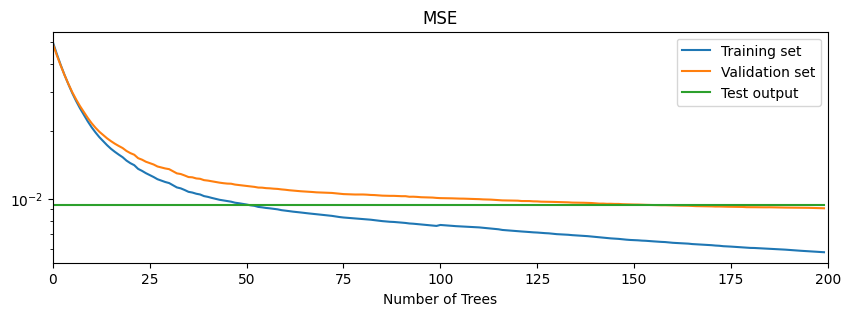

In [ ]:
"Plot Metrics"

fig, ax = plt.subplots(1,1,figsize=(10, 3))
ax.semilogy(results['train_mse']**2)  # the training set
plt.semilogy(results['valid_mse']**2)  # the validation set
plt.title('MSE')
plt.xlabel('Number of Trees')
plt.legend(['Training set','Validation set'])
plt.xlim([0,100*num_epochs])

plt.semilogy(np.ones((100*num_epochs,1))*mse_test)
plt.legend(['Training set','Validation set','Test output'])
plt.show()